In [199]:
%set_env ANTHROPIC_API_KEY=${ANTHROPIC_API_KEY}%set_env LANGSMITH_TRACING=true%set_env LANGSMITH_API_KEY=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%set_env TAVILY_API_KEY=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%set_env OPENAI_API_KEY=${OPENAI_API_KEY}%set_env LANGCHAIN_API_KEY=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%set_env LANGCHAIN_TRACING_V2=true%set_env LANGCHAIN_PROJECT="Multi-agent Collaboration"

env: ANTHROPIC_API_KEY=${ANTHROPIC_API_KEY}
env: LANGSMITH_TRACING=true
env: LANGSMITH_API_KEY=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
env: TAVILY_API_KEY=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
env: OPENAI_API_KEY=${OPENAI_API_KEY}
env: LANGCHAIN_API_KEY=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
env: LANGCHAIN_TRACING_V2=true
env: LANGCHAIN_PROJECT="Multi-agent Collaboration"


In [200]:
import config# from langchain.chat_models import ChatOpenAIfrom langchain_openai import ChatOpenAIfrom langchain_anthropic import ChatAnthropicfrom langchain.schema import AIMessage, HumanMessage, SystemMessageimport pandas as pdimport pandasql as psqldef ChatAnthropicSKT(model="anthropic/claude-3-5-sonnet-20240620"):    llm_api_key = config.CUSTOM_API_KEY"https://api.platform.a15t.com/v1"    # model = "anthropic/claude-3-5-sonnet-20240620"    model = ChatOpenAI(        temperature=0,          openai_api_key=llm_api_key,         openai_api_base=llm_api_url,         model=model        )    return modelllm = ChatAnthropicSKT()# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")# llm = ChatOpenAI(model="gpt-3.5-turbo")# llm = ChatAnthropicSKT(model="azure/openai/gpt-4-1106")

In [201]:
from langchain_core.messages import (    BaseMessage,    HumanMessage,    ToolMessage,)from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholderfrom langgraph.graph import END, StateGraph, STARTdef create_agent(llm, tools, system_message: str):    """Create an agent."""    prompt = ChatPromptTemplate.from_messages(        [            (                "system",                "You are a helpful AI assistant, collaborating with other assistants."                " Use the provided tools to progress towards answering the question."                " If you are unable to fully answer, that's OK, another assistant with different tools "                " will help where you left off. Execute what you can to make progress."                " If you have the final answer or deliverable or you meet user's request,"                " prefix your response with 'TASK_COMPLETED' so the supervisor knows that your task is completed."                " You have access to the following tools: {tool_names}.\n{system_message}",            ),            MessagesPlaceholder(variable_name="messages"),        ]    )    prompt = prompt.partial(system_message=system_message)    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))    return prompt | llm.bind_tools(tools)from langchain.agents import AgentExecutor, create_openai_functions_agentdef create_agent2(    llm: ChatOpenAI,    tools: list,    system_prompt: str,) -> str:    """Create a function-calling agent and add it to the graph."""    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."    " Do not ask for clarification."    " Your other team members (and other teams) will collaborate with you with their own specialties."    " You are a helpful AI assistant, collaborating with other assistants."    " Use the provided tools to progress towards answering the question."    " If you are unable to fully answer, that's OK, another assistant with different tools "    " will help where you left off. Execute what you can to make progress."    " If you have the final answer or deliverable or you meet user's request,"    " prefix your response with 'TASK_COMPLETED' so the supervisor knows that your task is completed."    " You have access to the following tools: {tool_names}."    prompt = ChatPromptTemplate.from_messages(        [            (                "system",                system_prompt,            ),            MessagesPlaceholder(variable_name="messages"),            MessagesPlaceholder(variable_name="agent_scratchpad"),        ]    )    agent = create_openai_functions_agent(llm, tools, prompt)    executor = AgentExecutor(agent=agent, tools=tools)    return executor

In [202]:
from typing import List, Optional, Dict, Any, Annotatedfrom langchain.agents import AgentExecutor, create_openai_functions_agentfrom langchain.output_parsers.openai_functions import JsonOutputFunctionsParserfrom langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholderfrom langchain_openai import ChatOpenAIfrom langgraph.graph import END, StateGraph, STARTdef create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:    """An LLM-based router."""    options = ["FINISH"] + members    function_def = {        "name": "route",        "description": "Select the next role.",        "parameters": {            "title": "routeSchema",            "type": "object",            "properties": {                "next": {                    "title": "Next",                    "anyOf": [                        {"enum": options},                    ],                },            },            "required": ["next"],        },    }    prompt = ChatPromptTemplate.from_messages(        [            ("system", system_prompt),            MessagesPlaceholder(variable_name="messages"),            (                "system",                "Given the conversation above, who should act next?"                " Or should we FINISH? Select one of: {options}",            ),        ]    ).partial(options=str(options), team_members=", ".join(members))    return (        prompt        | llm.bind_functions(functions=[function_def], function_call="route")        | JsonOutputFunctionsParser()    )from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholderfrom langchain_core.messages import HumanMessage, SystemMessage, FunctionMessage, AIMessage, ToolMessage    from typing import List, Dict, Callable, Uniondef create_team_supervisor2(llm, system_prompt: str, members: List[str]) -> Callable:    """An LLM-based router compatible with Claude."""    options = ["FINISH"] + members        prompt = ChatPromptTemplate.from_messages([        ("system", system_prompt),        MessagesPlaceholder(variable_name="messages"),        (            "human",            "Given the conversation above, who should act next?"            " Or should we FINISH? Select one of: {options}"            " Respond with only the name of the next actor or FINISH, nothing else."        ),    ]).partial(options=str(options), team_members=", ".join(members))    def route(state: Dict[str, Union[List[Dict], str, None]]) -> Dict[str, Any]:        messages = state.get('messages', [])                # Process messages to focus only on content        processed_messages = []        for msg in messages:            if isinstance(msg, dict):                if msg.get('type') == 'human':                    processed_messages.append(HumanMessage(content=msg['content']))                elif msg.get('type') == 'ai':                    processed_messages.append(AIMessage(content=msg['content']))                elif msg.get('type') == 'system':                    processed_messages.append(SystemMessage(content=msg['content']))                elif msg.get('type') == 'function':                    processed_messages.append(FunctionMessage(content=msg['content'], name=msg.get('name', 'function')))                elif msg.get('type') == 'tool':                    processed_messages.append(ToolMessage(content=msg['content'], tool_call_id=msg.get('tool_call_id', 'unknown')))            elif isinstance(msg, (HumanMessage, AIMessage, SystemMessage, FunctionMessage)):                processed_messages.append(msg.__class__(content=msg.content))            elif isinstance(msg, ToolMessage):                processed_messages.append(SystemMessage(content=msg.content))            else:                # For any other type of message, we'll convert it to a string and use it as a HumanMessage                processed_messages.append(HumanMessage(content=str(msg)))                chat_history = []        for i in range(0, len(processed_messages)):            if len(chat_history)<1:                chat_history.append(processed_messages[i])            else:                if isinstance(chat_history[-1], (AIMessage, SystemMessage)) and isinstance(processed_messages[i], (AIMessage, SystemMessage)):                    chat_history[-1] = AIMessage(content=chat_history[-1].content + " " + processed_messages[i].content)                else:                    chat_history.append(processed_messages[i])        # Format the prompt with the processed messages        formatted_prompt = prompt.format_messages(messages=chat_history)                # Invoke the LLM        # print(f"------Formatted prompt: {formatted_prompt}")        # print(f"------processed_messages: {chat_history}")        response = llm.invoke(formatted_prompt)                next_actor = response.content.strip()                if next_actor not in options:            print(f"Invalid response from AI: {next_actor}. Defaulting to FINISH.")            next_actor = "FINISH"                # Create a new message for the supervisor's decision        supervisor_message = SystemMessage(content=f"Next actor: {next_actor}")                # Return the updated state        return {            "messages": [supervisor_message],            "sender": "supervisor",            "next": next_actor        }    return route

In [203]:
import json
from typing import Annotated, List

from langchain_core.tools import tool

from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from typing_extensions import TypedDict

@tool
def check_schema(
    # dataframe_json: Annotated[str, "dataframe in JSON format."], 
    dataframe_path: Annotated[str, "path to the dataframe."]
):    
    """
    Check the schema of a dataframe.
    
    Args:
        # dataframe_json (str): The dataframe in JSON format.
        dataframe_path (str): The path to the dataframe.
    
    Returns:
        str: The schema of the dataframe.
    """

    # print("=====check_schema>dataframe_json: ",dataframe_json)
    # print("=====check_schema>dataframe_path: ",dataframe_path)

    try:
        # If it's a string, try to parse it as JSON
        # try:
        #     if isinstance(dataframe_json, str):
        #         json_data = json.loads(dataframe_json)
        #     else:
        #         json_data = dataframe_json
            
        #     # Create a DataFrame
        #     df = pd.DataFrame(json_data)
        # except:
        #     df = pd.read_csv(dataframe_path)

        df = pd.read_csv(dataframe_path)
        
        # Get the schema
        schema = df.dtypes.to_string()
        return f"DataFrame schema:\n{schema}"
    except json.JSONDecodeError as e:
        error_msg = f"Error decoding JSON string: {str(e)}"
        return error_msg
    except Exception as e:
        error_msg = f"Error checking schema: {str(e)}"
        return error_msg

@tool
def generate_sql_query(
    user_request: Annotated[str,"user request to generate a sql query"],
    dataframe_schema: Annotated[str,"dataframe schema to generate a sql query"],
    dataframe_name: Annotated[str,"dataframe name to search"]
) -> str:
    """
    A tool to generate a SQL query based on the user request and schema in the message.
    """

    # print("=====generate_sql_query>dataframe_schema: ",dataframe_schema)
    # print("=====generate_sql_query>dataframe_name: ",dataframe_name)

    try:
        prompt = f"Given the following user request:'{user_request}' and schema:\n{dataframe_schema} and table name:'{dataframe_name}'\n\nGenerate a SQL query for the following message."
        sql_query = llm.invoke([HumanMessage(content=prompt)]).content
        return sql_query
    except Exception as e:
        return ""

# @tool
# def search_dataframe(
#     dataframe_json: Annotated[str, "dataframe in JSON format."], 
#     sql_query: Annotated[str, "SQL query to execute."]
# ) -> str:
#     """
#     A tool to search a dataframe using a SQL query from SQL_Expert.
#     """
#     print("=====search_dataframe>dataframe_json: ",dataframe_json)
#     print("=====search_dataframe>sql_query: ",sql_query)
#     try:
#         df = pd.read_json(dataframe_json)
#         result = psql.sqldf(sql_query, locals())
#         return result.to_json(orient='records')
#     except Exception as e:
#         return "[]"

@tool
def search_dataframe(
    dataframe_path: Annotated[str, "path to the dataframe."],
    sql_query: Annotated[str, "SQL query to execute."]
) -> str:
    """
    A tool to search a dataframe using a SQL query from SQL_Expert.
    """
    # print("=====search_dataframe>dataframe_path: ",dataframe_path)
    # print("=====search_dataframe>sql_query: ",sql_query)
    try:
        df = pd.read_csv(dataframe_path)
        # print("=====search_dataframe>result: ",stock_data_krx)
        result = psql.sqldf(sql_query, locals())
        return result.to_json(orient='records')
    except Exception as e:
        return "[]"

from pathlib import Path
WORKING_DIRECTORY = Path("data")

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"



In [204]:
import operatorfrom typing import Annotated, Sequence, TypedDictfrom langchain_openai import ChatOpenAI# This defines the object that is passed between each node# in the graph. We will create different nodes for each agent and toolclass AgentState(TypedDict):    messages: Annotated[Sequence[BaseMessage], operator.add]    sender: str

In [205]:
import functools

from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    new_state = state.copy()
    messages = state.get('messages', [])
    if isinstance(messages[-1], SystemMessage) and isinstance(messages[-2], AIMessage):
        messages.append(HumanMessage(content="Consider the previous conversation history."))
    elif isinstance(messages[-1], AIMessage):
        messages.append(HumanMessage(content="Consider the previous conversation history."))
    new_state['messages'] = messages
    # print(f">>>>>>>>agent_node>state({name}): ", new_state)
    result = agent.invoke(new_state)
    # print(f">>>>>>>>agent_node>name: ", result)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        # result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # print(f">>>>>>>>agent_node>result: ", result)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

def agent_node2(state, agent, name):
    # print(f">>>>>>>>agent_node>state({name}): ", state)
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

data_science_agent = create_agent(llm, [check_schema, generate_sql_query, search_dataframe], 
                                  "You are a data analyst specializing in understanding data schemas." 
                                  "You are a SQL expert who generates queries based on natural language requests and data schemas." 
                                  "You are a data scientist who executes SQL queries on pandas DataFrames and interprets the results"
                                  "If you have the final answer or deliverable or you meet user's request, prefix your response with 'TASK_COMPLETED' so the supervisor knows that your task is completed."
                                  )
data_scientist_node = functools.partial(agent_node, agent=data_science_agent, name="Data_Scientist")



In [206]:
doc_writer_agent = create_agent(
    llm,
    [write_document],
    "You are an expert writing a data from database tables.\n"
    # The {current_files} value is populated automatically by the graph state
    "Below are files currently in your directory:\n{current_files}",
)
doc_writer_agent_node = functools.partial(agent_node, agent=doc_writer_agent, name="Doc_Writer")


In [207]:
team_members_dict = {
        "Data_Scientist": data_scientist_node,
        "Doc_Writer": doc_writer_agent_node,
}

team_members = list(team_members_dict.keys())

supervisor_agent = create_team_supervisor2(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {', '.join(team_members)}." 
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    team_members,
)


In [208]:
from langgraph.prebuilt import ToolNode

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list, name:str) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
        self.name = name

    # The inputs are the state of the graph at the time of the node being called
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        # print("tool node input: ", inputs)
        outputs = []
        for tool_call in message.tool_calls: # tool_call : {'name': 'tavily_search_results_json', 'args': {'query': 'langchain'}, 'id': 'toolu_0196pDFQjAVMseyd5RX2vnqv', 'type': 'tool_call'}
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # print(">>>>>>tool node outputs: ", outputs)
        return {
            "messages": outputs
            # ,"sender": self.name
            }

tools_ds = [generate_sql_query, check_schema, search_dataframe]
tools_dw = [write_document]

# tool_node = ToolNode(tools)

tool_node_ds = BasicToolNode(tools_ds, "tools_ds")
tool_node_dw = BasicToolNode(tools_dw, "tools_dw")


In [209]:
# Either agent can decide to endfrom typing import Literaldef router(state) -> Literal["tools_ds", "tools_dw", "__end__", "continue"]:    # This is the router    messages = state["messages"]    last_message = messages[-1]        if last_message.tool_calls:        # The previous agent is invoking a tool        # print(f">>>>>>router>last_message: ",[d['name'] for d in last_message.tool_calls])        if any([d['name'] in [tool.name for tool in tools_ds] for d in last_message.tool_calls]):            return "tools_ds"        elif any([d['name'] in [tool.name for tool in tools_dw] for d in last_message.tool_calls]):            return "tools_dw"    if "TASK_COMPLETED" in last_message.content:        # Any agent decided the work is done        # print(f"--------router>last_message: ",last_message.content)        return "__end__"    # print(f">>>>>>router>last_message: ","continue")    return "continue"def route_tools(    state,) -> Literal[team_members]:    # """    # Use in the conditional_edge to route to the ToolNode if the last message    # has tool calls. Otherwise, route to the end.    # """    # if isinstance(state, list):    #     ai_message = state[-1]    # elif messages := state.get("messages", []):    #     ai_message = messages[-1]    # else:    #     raise ValueError(f"No messages found in input state to tool_edge: {state}")    # if hasattr(ai_message, "tools") and len(ai_message.tool_calls) > 0:    #     return "tools"    # print(f">>>>>>route_tools>state: ",state)    return state['sender']

In [210]:
workflow = StateGraph(AgentState)workflow.add_node("supervisor", supervisor_agent)workflow.add_node("tools_ds", tool_node_ds)workflow.add_node("tools_dw", tool_node_dw)for agt, nd in team_members_dict.items():    workflow.add_node(agt, nd)    workflow.add_edge(agt, "supervisor")    workflow.add_conditional_edges(    "supervisor",    lambda x: x["next"],    dict(        **{d:d for d in team_members},        **{"FINISH": END}        ),)workflow.add_conditional_edges(    "Data_Scientist",    router,    {"continue": "supervisor", "tools_ds": "tools_ds", "__end__": "supervisor"},)workflow.add_conditional_edges(    "Doc_Writer",    router,    {"continue": "supervisor", "tools_dw": "tools_dw", "__end__": "supervisor"},)workflow.add_conditional_edges(    "tools_ds",    # Each agent node updates the 'sender' field    # the tool calling node does not, meaning    # this edge will route back to the original agent    # who invoked the tool    route_tools,    {        # "supervisor": "supervisor",        "Data_Scientist": "Data_Scientist",        # "tools_ds": "tools_ds",    },)workflow.add_conditional_edges(    "tools_dw",    # Each agent node updates the 'sender' field    # the tool calling node does not, meaning    # this edge will route back to the original agent    # who invoked the tool    route_tools,    {        # "supervisor": "supervisor",        "Doc_Writer": "Doc_Writer",        # "tools_dw": "tools_dw",    },)workflow.add_edge(START, "supervisor")graph = workflow.compile()

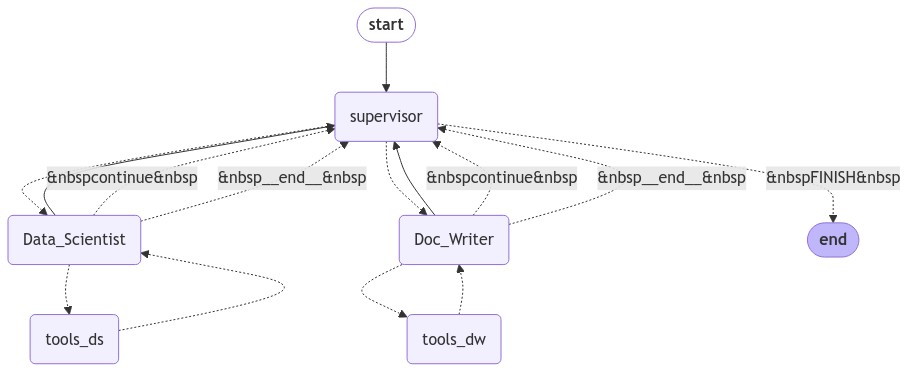

In [211]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [212]:
user_input = """select the rows of symbol '000100.KS' since this month.Use the following information:    dataframe_path="data/stock_data_krx.csv"    dataframe_name='df'And then, write the results to a document as a name of 'selected_data.csv'"""recursion_limit = 5for event in graph.stream({"messages": [("user", user_input)]}):    # print("Workflow output:", event)    for value in event.values():        if isinstance(value["messages"][-1], BaseMessage):            # print("Assistant:", value["messages"][-1].content)            value["messages"][-1].pretty_print()# from langchain_core.messages import BaseMessage# while True:#     user_input = input("User: ")#     if user_input.lower() in ["quit", "exit", "q"]:#         print("Goodbye!")#         break#     for event in graph.stream({"messages": [("user", user_input)]}):#         for value in event.values():#             if isinstance(value["messages"][-1], BaseMessage):#                 # print("Assistant:", value["messages"][-1].content)#                 value["messages"][-1].pretty_print()

================================ System Message ================================

Next actor: Data_Scientist
================================== Ai Message ==================================
Name: Data_Scientist

Certainly! I'll help you select the rows for the symbol '000100.KS' since this month from the given dataframe and then write the results to a CSV file. Let's break this down into steps:

1. First, we'll check the schema of the dataframe to ensure we have the correct columns.
2. Then, we'll generate and execute a SQL query to select the desired data.
3. Finally, we'll save the results to a CSV file.

Let's start by checking the schema:
Tool Calls:
  check_schema (toolu_017cLcQPYx6bUc6j7GhKEasy)
 Call ID: toolu_017cLcQPYx6bUc6j7GhKEasy
  Args:
    dataframe_path: data/stock_data_krx.csv
================================= Tool Message =================================
Name: check_schema

"DataFrame schema:\ndate          object\nopen         float64\nhigh         float64\nlow      